In [2]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.8/330.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 84.3 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=989a332c7897691c6b44e34f762f250053b5315dc881722acafa9036fba30825
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


In [4]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 8.8 MB/s eta 0:00:00


In [5]:
!pip install nlpaug
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.6 MB/s eta 0:00:00


# Data Preparation

In [6]:
import pandas as pd
import numpy as np
import torch
import time
import random
import psutil
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW

import re
import nltk
import emoji
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nlpaug.augmenter.word as naw

# Download resource NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## SESUAIIN PATH

In [14]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

DATA_PATH = '/content/drive/MyDrive/FINPRO_DEEPLEARNING/dataset'




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
#combined_data
combined_data = pd.read_csv(f'{DATA_PATH}/Combined Data.csv')
combined_data = combined_data.rename(columns={'statement': 'text', 'status': 'label'})
combined_data['label'] = combined_data['label'].map({
    'Normal': 0,
    'Depression': 1,
    'Suicidal': 2,
    'Anxiety': 3,
    'Bipolar': 4,
    'Stress': 5,
    'Personality disorder': 6
})

#data_to_be_cleansed
data_to_be_cleansed = pd.read_csv(f'{DATA_PATH}/data_to_be_cleansed.csv')
data_to_be_cleansed = data_to_be_cleansed.rename(columns={'text': 'text', 'target': 'label'})
data_to_be_cleansed['label'] = data_to_be_cleansed['label'].astype(str).map({
    '0': 5,  # Stress
    '1': 1,  # Depression
    '2': 4,  # Bipolar
    '3': 6,  # Personality disorder
    '4': 3   # Anxiety
})

#deppression_dataset
depression_dataset = pd.read_csv(f'{DATA_PATH}/depression_dataset_reddit_cleaned.csv')
depression_dataset = depression_dataset.rename(columns={'clean_text': 'text', 'is_depression': 'label'})
depression_dataset['label'] = depression_dataset['label'].astype(str).map({
    '0': 0,  # Normal
    '1': 1   # Depression
})

#mental_health
mental_health = pd.read_csv(f'{DATA_PATH}/mental-health.csv')
mental_health = mental_health.rename(columns={'text': 'text', 'label': 'label'})
mental_health['label'] = mental_health['label'].astype(str).str.strip().str.lower().map({
    'depression': 1,
    'suicidewatch': 2
})

#reddit-combi
reddit_combi = pd.read_csv(f'{DATA_PATH}/Reddit_Combi.csv', sep=';', encoding='utf-8')
reddit_combi = reddit_combi.rename(columns={'body': 'text', 'label': 'label'})
reddit_combi['label'] = reddit_combi['label'].astype(str).map({
    '0': 0,
    '1': 5
})

#stress_data
stress_data = pd.read_csv(f'{DATA_PATH}/Stress.csv')
stress_data = stress_data.rename(columns={'text': 'text', 'label': 'label'})
stress_data['label'] = stress_data['label'].astype(str).map({
    '0': 0,
    '1': 5
})

#suicide_ideation
suicide_ideation = pd.read_csv(f'{DATA_PATH}/Suicide_Ideation_Dataset(Twitter-based).csv', dtype={'Suicide': str})
suicide_ideation = suicide_ideation.rename(columns={'Tweet': 'text', 'Suicide': 'label'})
suicide_ideation['label'] = suicide_ideation['label'].str.strip().map({
    'Not Suicide post': 0,
    'Potential Suicide post': 2
})

#twitter_full
twitter_full = pd.read_csv(f'{DATA_PATH}/Twitter_Full.csv', sep=';', encoding='utf-8', on_bad_lines='skip')
twitter_full = twitter_full.rename(columns={'content': 'text', 'labels': 'label'})
twitter_full['label'] = twitter_full['label'].astype(str).map({
    '0': 0,
    '1': 5
})

In [16]:
dfs = [combined_data,data_to_be_cleansed,depression_dataset,mental_health,reddit_combi,stress_data,suicide_ideation,twitter_full]
final_df = pd.concat(dfs, ignore_index=True)

In [17]:
final_df.info()
final_df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103743 entries, 0 to 103742
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        59000 non-null   float64
 1   text              103016 non-null  object 
 2   label             103743 non-null  int64  
 3   title             9080 non-null    object 
 4   Body_Title        3123 non-null    object 
 5   Unnamed: 4        0 non-null       float64
 6   subreddit         2838 non-null    object 
 7   post_id           2838 non-null    object 
 8   sentence_range    2838 non-null    object 
 9   confidence        2838 non-null    float64
 10  social_timestamp  2838 non-null    float64
 11  hashtags          8892 non-null    object 
 12  Unnamed: 3        0 non-null       float64
dtypes: float64(5), int64(1), object(7)
memory usage: 10.3+ MB


,count
label,
1,30808
0,27472
2,21306
5,12617
3,5076
4,4062
6,2402


In [18]:
# Bersihkan
final_df = final_df[['text', 'label']]
final_df = final_df.dropna(subset=['text', 'label'])
final_df['label'] = final_df['label'].astype(int)
final_df['text'] = final_df['text'].astype(str).str.strip()
final_df = final_df.drop_duplicates()

In [19]:
final_df.info()
final_df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 67051 entries, 0 to 103742
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    67051 non-null  object
 1   label   67051 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


,count
label,
0,20531
1,16067
2,10644
5,10141
3,4568
4,3310
6,1790


In [20]:
print("final_df count:", len(final_df))
print("Empty text count:", (final_df['text'].str.strip() == '').sum())
print("label NaN count:", final_df['label'].isnull().sum())
print("NaN text count:", final_df['text'].isnull().sum())

final_df count: 67051
Empty text count: 0
label NaN count: 0
NaN text count: 0


Sample Data:
                                                text  label
0                                         oh my gosh      3
1  trouble sleeping, confused mind, restless hear...      3
2  All wrong, back off dear, forward doubt. Stay ...      3
3  I've shifted my focus to something else but I'...      3
4  I'm restless and restless, it's been a month n...      3

Missing Values:
text     0
label    0
dtype: int64

Total Duplicate Rows: 0

Label Distribution:
label
0    20531
1    16067
2    10644
3     4568
4     3310
5    10141
6     1790
Name: count, dtype: int64

Text Length (in Words):
count    67051.000000
mean       107.286260
std        160.867043
min          1.000000
25%         18.000000
50%         51.000000
75%        138.000000
max       6300.000000
Name: text_length, dtype: float64


/tmp/ipython-input-1325414890.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=final_df['label'], palette='pastel')


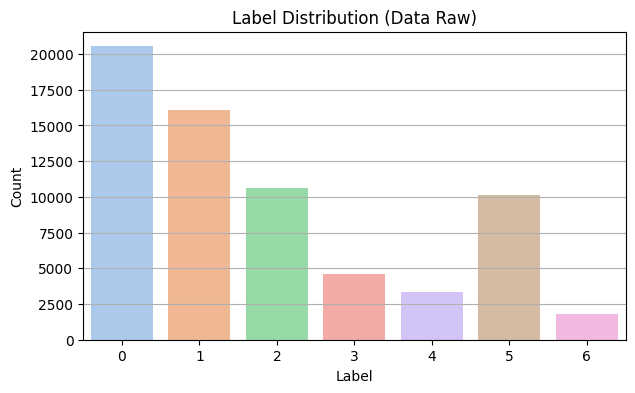

In [21]:
print("Sample Data:")
print(final_df.head())

print("\nMissing Values:")
print(final_df.isnull().sum())

print(f"\nTotal Duplicate Rows: {final_df.duplicated().sum()}")

print("\nLabel Distribution:")
print(final_df['label'].value_counts().sort_index())

final_df['text_length'] = final_df['text'].apply(lambda x: len(x.split()))
print("\nText Length (in Words):")
print(final_df['text_length'].describe())

plt.figure(figsize=(7,4))
sns.countplot(x=final_df['label'], palette='pastel')
plt.title('Label Distribution (Data Raw)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

In [22]:
final_df.to_csv('mental_health_dataset.csv', index=False)
print(f"Success! Total data: {len(final_df)}")

Success! Total data: 67051


# Data Preprocessing

In [23]:
df = pd.read_csv('mental_health_dataset.csv')
df.info()
df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67051 entries, 0 to 67050
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         67051 non-null  object
 1   label        67051 non-null  int64 
 2   text_length  67051 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


,count
label,
0,20531
1,16067
2,10644
5,10141
3,4568
4,3310
6,1790


In [ ]:
# Initialization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Convert POS tag to WordNet form
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": 'a', "N": 'n', "V": 'v', "R": 'r'}
    return tag_dict.get(tag, 'n')  # Default 'n' for noun

# Delete emoji
def remove_emoji(text):
    return emoji.replace_emoji(text, replace='')

# Delete repeated letters
def remove_repeated_letters(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)

# Preprocessing
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove URL
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove emojis
    text = remove_emoji(text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove repeated letters
    text = remove_repeated_letters(text)

    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Lemmatization with POS tagging + remove stopwords
    cleaned_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(word))
        for word in tokens
        if word not in stop_words and len(word) > 1
    ]

    return ' '.join(cleaned_tokens)

# Apply preprocessing to all texts
df['text'] = df['text'].astype(str).apply(preprocess_text)

# Remove empty texts after cleaning
df = df[df['text'].str.strip() != '']

print(f"Success! Dataset cleaned, total data: {len(df)}")

Sample Data:
                                                text  label  text_length
0                                         oh my gosh      3            3
1  trouble sleeping, confused mind, restless hear...      3           10
2  All wrong, back off dear, forward doubt. Stay ...      3           14
3  I've shifted my focus to something else but I'...      3           11
4  I'm restless and restless, it's been a month n...      3           14

Missing Values:
text           0
label          0
text_length    0
dtype: int64

Total Duplicate Rows: 0

Label Distribution:
label
0    20531
1    16067
2    10644
3     4568
4     3310
5    10141
6     1790
Name: count, dtype: int64

Text Length (in Words):
count    67051.000000
mean       107.286260
std        160.867043
min          1.000000
25%         18.000000
50%         51.000000
75%        138.000000
max       6300.000000
Name: text_length, dtype: float64


/tmp/ipython-input-4241672665.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='pastel')


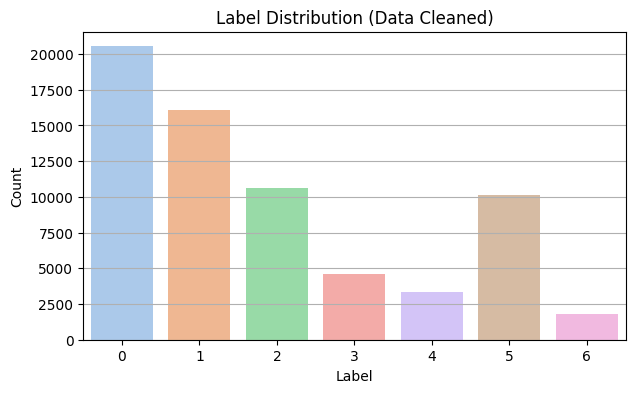

In [24]:
print("Sample Data:")
print(df.head())

print("\nMissing Values:")
print(df.isnull().sum())

print(f"\nTotal Duplicate Rows: {df.duplicated().sum()}")

print("\nLabel Distribution:")
print(df['label'].value_counts().sort_index())

df['text_length'] = df['text'].apply(lambda x: len(x.split()))
print("\nText Length (in Words):")
print(df['text_length'].describe())

plt.figure(figsize=(7,4))
sns.countplot(x=df['label'], palette='pastel')
plt.title('Label Distribution (Data Cleaned)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

# Handling Imbalanced

In [25]:
# Get synonym from WordNet
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

# Synonym Replacement
def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if get_synonyms(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

# Augmentation minority class
def augment_minority_class(df, label, num_aug=2):
    subset = df[df['label'] == label]
    augmented = []
    for text in subset['text']:
        for _ in range(num_aug):
            aug_text = synonym_replacement(text, n=1)
            augmented.append({'text': aug_text, 'label': label})
    return pd.DataFrame(augmented)

# Apply augmentation to minority labels
minority_labels = [3, 4, 6]  # Anxiety, Bipolar, Personality Disorder
augmented_parts = [augment_minority_class(df, lbl, num_aug=2) for lbl in minority_labels]
augmented_df = pd.concat([df] + augmented_parts).drop_duplicates().reset_index(drop=True)  # df → df + augmented
print("Total data after augmentation:", len(augmented_df))


Total data after augmentation: 86267


In [26]:
def augment_minority_nlpaug(df, label, num_aug=2):
    syn_aug = naw.SynonymAug(aug_src='wordnet', lang='eng')
    subset = df[df['label'] == label]
    augmented = []

    for text in subset['text']:
        for _ in range(num_aug):
            aug_text = syn_aug.augment(text)
            if isinstance(aug_text, list):
                aug_text = ' '.join(aug_text)
            augmented.append({'text': aug_text, 'label': label})
    return pd.DataFrame(augmented)

# Example application
minority_labels = [3, 4, 6]  # Anxiety, Bipolar, Personality Disorder
augmented_parts = [augment_minority_nlpaug(df, lbl, num_aug=2) for lbl in minority_labels]
augmented_df = pd.concat([df] + augmented_parts).drop_duplicates().reset_index(drop=True)
print("Total data after augmentation:", len(augmented_df))

Total data after augmentation: 86357



Sample Data:
                                                text  label  text_length
0                                         oh my gosh      3          3.0
1  trouble sleeping, confused mind, restless hear...      3         10.0
2  All wrong, back off dear, forward doubt. Stay ...      3         14.0
3  I've shifted my focus to something else but I'...      3         11.0
4  I'm restless and restless, it's been a month n...      3         14.0

Missing Values:
text               0
label              0
text_length    19306
dtype: int64

Total Duplicate Rows: 0

Label Distribution:
label
0    20531
1    16067
2    10644
3    13674
4     9930
5    10141
6     5370
Name: count, dtype: int64

Text Length (in Words):
count    86357.000000
mean       123.008824
std        171.146650
min          1.000000
25%         22.000000
50%         70.000000
75%        163.000000
max       6300.000000
Name: text_length, dtype: float64


/tmp/ipython-input-3590651268.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=augmented_df['label'], palette='Set2')


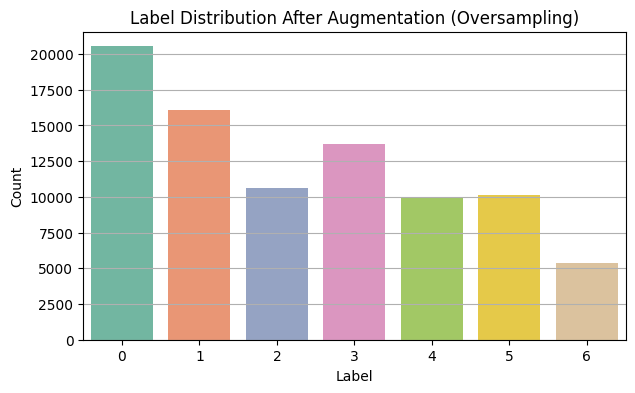

In [27]:
print("\nSample Data:")
print(augmented_df.head())

print("\nMissing Values:")
print(augmented_df.isnull().sum())

print(f"\nTotal Duplicate Rows: {augmented_df.duplicated().sum()}")

print("\nLabel Distribution:")
print(augmented_df['label'].value_counts().sort_index())

augmented_df['text_length'] = augmented_df['text'].apply(lambda x: len(x.split()))
print("\nText Length (in Words):")
print(augmented_df['text_length'].describe())

plt.figure(figsize=(7,4))
sns.countplot(x=augmented_df['label'], palette='Set2')
plt.title('Label Distribution After Augmentation (Oversampling)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

In [28]:
augmented_df.to_csv('mental_health_dataset_augmented.csv', index=False)
print(f"Success! Total data: {len(augmented_df)}")

Success! Total data: 86357


In [29]:
from google.colab import files
files.download('mental_health_dataset_augmented.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>